# Universidad Internacional de La Rioja  

### Máster Universitario en Visual Analytics and Big Data  

---

### **Predicción y Análisis de la Demanda y Suministro de Productos entre la Comunidad Andina y España**  
**Presentado por:** Danilo Andrés Beleño Villafañe  

---

### **Notebook 8: Modelado - Prueba Random Forest Regressor 2**  


In [29]:
from utils.bigquery_handler import BigQueryHandler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [30]:
bqh = BigQueryHandler('unir-predictiv0-andina-espana')

query = f"""
    SELECT 
        fecha, 
        anio, 
        mes, 
        tipo_movimiento_cod, 
        cod_pais, 
        cod_provincia, 
        cod_comunidad, 
        cod_taric, 
        dolares--, 
        --kilogramos
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    WHERE nivel_taric = '1' AND tipo_movimiento_cod = 'I' AND cod_taric = '08'
"""

data = bqh.get_bigquery_data(query)

In [32]:
df = data.copy()

df['fecha'] = pd.to_datetime(df['fecha'])

categorical_features = ["tipo_movimiento_cod", "cod_pais", "cod_provincia", "cod_comunidad", "cod_taric"]
encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_categorical = encoder.fit_transform(df[categorical_features])
encoded_columns = encoder.get_feature_names_out(categorical_features)

encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_columns)

X = pd.concat([df[["anio", "mes"]], encoded_df], axis=1)

scaler = StandardScaler()
y_scaled = scaler.fit_transform(df[["dolares"]])

X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(n_estimators=50, random_state=42)

rf_regressor.fit(X_train, y_train.ravel())

y_pred_scaled = rf_regressor.predict(X_test)

y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Squared Error (MSE): 226265995244.99
R-squared (R²): 0.90


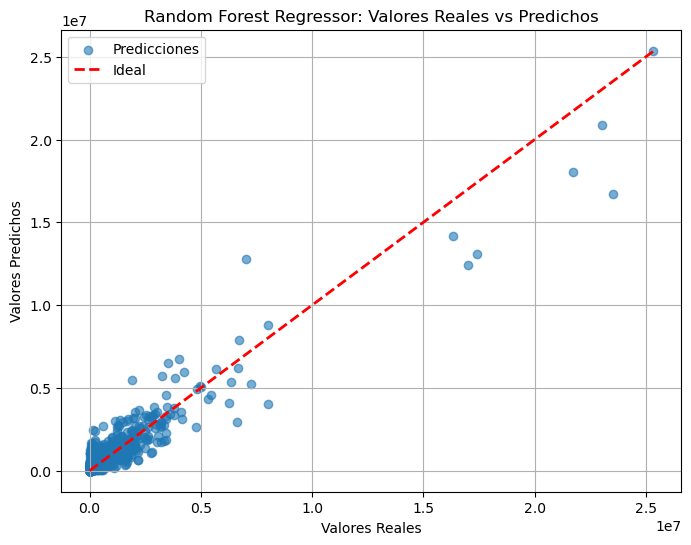

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.6, label="Predicciones")
plt.plot(
    [y_test_original.min(), y_test_original.max()],
    [y_test_original.min(), y_test_original.max()],
    'r--',
    lw=2,
    label='Ideal'
)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Random Forest Regressor: Valores Reales vs Predichos')
plt.legend()
plt.grid(True)
plt.show()


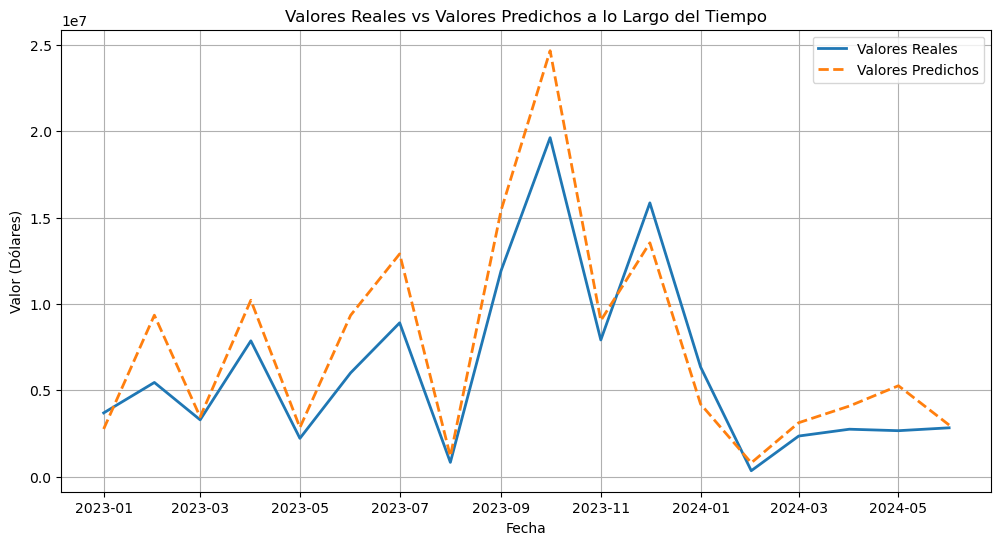

In [35]:
resultados = pd.DataFrame({
    "fecha": df.iloc[X_test.index]["fecha"],
    "valores_reales": y_test_original.ravel(),
    "valores_predichos": y_pred_original.ravel()
})

resultados = resultados[resultados["fecha"] > "2022-12-31"]

resultados = resultados.groupby("fecha", as_index=False).sum()

resultados = resultados.sort_values("fecha")

plt.figure(figsize=(12, 6))
plt.plot(resultados["fecha"], resultados["valores_reales"], label="Valores Reales", linewidth=2)
plt.plot(resultados["fecha"], resultados["valores_predichos"], label="Valores Predichos", linewidth=2, linestyle='--')
plt.xlabel("Fecha")
plt.ylabel("Valor (Dólares)")
plt.title("Valores Reales vs Valores Predichos a lo Largo del Tiempo")
plt.legend()
plt.grid(True)
plt.show()
